#Skin Disease Classification - Pre Training Model EfficientNetB3


# 727 Total Images from Robo flow 5 Classes: {'Acne': 0, 'Eczema': 1, 'Keratosis Pilaris': 2, 'Psoriasis': 3, 'Warts': 4}


In [ ]:
# Libraries
from roboflow import Roboflow
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# PATHS

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Private")
project = rf.workspace("khalid-khubrani").project("skin-rs9zg-1mm4t")
version = project.version(1)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Skin-1 in folder:: 100%|██████████| 747/747 [00:00<00:00, 6163.24it/s]


# DATA GENERATORS

In [ ]:
train_dir = dataset.location + "/train"
val_dir   = dataset.location + "/valid"
test_dir  = dataset.location + "/test"

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_data = val_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

num_classes = len(train_data.class_indices)
print("🩺 Classes:", train_data.class_indices)


Found 584 images belonging to 5 classes.
Found 72 images belonging to 5 classes.
Found 71 images belonging to 5 classes.
🩺 Classes: {'Acne': 0, 'Eczema': 1, 'Keratosis Pilaris': 2, 'Psoriasis': 3, 'Warts': 4}


#  BUILD MODEL (Fine-Tuning Last 25 Layers)


In [ ]:
base_model = EfficientNetB3(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

for layer in base_model.layers[:-25]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)




# MODEL COMPILE

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# MODEL SUMMARY

In [ ]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_12        │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 224, 224,  │          7 │ rescaling_12[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_13        │ (None, 224, 224,  │          0 │ normalization_6[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_13[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,791,220 (41.17 MB)

 Trainable params: 3,543,759 (13.52 MB)

 Non-trainable params: 7,247,461 (27.65 MB)

# CALLBACKS

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_skin_model.h5", monitor='val_accuracy', save_best_only=True
)

# TRAIN MODEL

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3453 - loss: 1.5286

19/19 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.3507 - loss: 1.5217 - val_accuracy: 0.7222 - val_loss: 1.0928
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.7640 - loss: 0.8339 - val_accuracy: 0.7222 - val_loss: 0.8324
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7971 - loss: 0.6800

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 544ms/step - accuracy: 0.7973 - loss: 0.6796 - val_accuracy: 0.7500 - val_loss: 0.7253
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.8124 - loss: 0.5706 - val_accuracy: 0.7500 - val_loss: 0.6686
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9153 - loss: 0.3888

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 463ms/step - accuracy: 0.9138 - loss: 0.3909 - val_accuracy: 0.7639 - val_loss: 0.6332
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8251 - loss: 0.4533

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - accuracy: 0.8264 - loss: 0.4513 - val_accuracy: 0.7917 - val_loss: 0.6187
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8873 - loss: 0.3762

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 438ms/step - accuracy: 0.8876 - loss: 0.3755 - val_accuracy: 0.8056 - val_loss: 0.5853
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step - accuracy: 0.9260 - loss: 0.3286 - val_accuracy: 0.7917 - val_loss: 0.5721
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 483ms/step - accuracy: 0.8997 - loss: 0.3032 - val_accuracy: 0.7917 - val_loss: 0.5517
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.9336 - loss: 0.2733 - val_accuracy: 0.8056 - val_loss: 0.5350
Epoch 11/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.9142 - loss: 0.2574 - val_accuracy: 0.8056 - val_loss: 0.5178
Epoch 12/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - accuracy: 0.9172 - loss: 0.2674 - val_accuracy: 0.8056 - val_loss: 0.4915
Epoch 13/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.9667 - loss: 0.2055 - val_accuracy: 0.8056 - val_loss: 0.4835
Epoch 14/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9386 - loss: 0.2195

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - accuracy: 0.9390 - loss: 0.2187 - val_accuracy: 0.8333 - val_loss: 0.4881
Epoch 15/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.9600 - loss: 0.1769 - val_accuracy: 0.8333 - val_loss: 0.4894
Epoch 16/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.9374 - loss: 0.2168 - val_accuracy: 0.8333 - val_loss: 0.5167
Epoch 17/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - accuracy: 0.9532 - loss: 0.1621 - val_accuracy: 0.8333 - val_loss: 0.4830
Epoch 18/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.9660 - loss: 0.1456 - val_accuracy: 0.8333 - val_loss: 0.4675
Epoch 19/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 445ms/step - accuracy: 0.9525 - loss: 0.1624 - val_accuracy: 0.8333 - val_loss: 0.4746
Epoch 20/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - accuracy: 0.9602 - loss: 0.1571 - val_accuracy: 0.8333 - val_loss: 0.4700
Epoch 21/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.9593 - loss: 0.1303 - val_accuracy: 0.8194

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 413ms/step - accuracy: 0.9672 - loss: 0.1403 - val_accuracy: 0.8611 - val_loss: 0.4422
Epoch 24/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.9693 - loss: 0.1113 - val_accuracy: 0.8333 - val_loss: 0.4818
Epoch 25/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.9800 - loss: 0.0996 - val_accuracy: 0.8472 - val_loss: 0.4438
Epoch 26/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.9851 - loss: 0.0769 - val_accuracy: 0.8611 - val_loss: 0.4349
Epoch 27/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 445ms/step - accuracy: 0.9643 - loss: 0.1195 - val_accuracy: 0.8333 - val_loss: 0.4713
Epoch 28/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9790 - loss: 0.0746 - val_accuracy: 0.8611 - val_loss: 0.4615
Epoch 29/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9634 - loss: 0.1071

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step - accuracy: 0.9640 - loss: 0.1060 - val_accuracy: 0.8750 - val_loss: 0.4299
Epoch 30/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 432ms/step - accuracy: 0.9823 - loss: 0.0694 - val_accuracy: 0.8750 - val_loss: 0.4352
Epoch 31/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.9860 - loss: 0.0821 - val_accuracy: 0.8472 - val_loss: 0.4872
Epoch 32/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step - accuracy: 0.9773 - loss: 0.0863 - val_accuracy: 0.8472 - val_loss: 0.4445
Epoch 33/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9732 - loss: 0.0770 - val_accuracy: 0.8472 - val_loss: 0.4624
Epoch 34/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - accuracy: 0.9857 - loss: 0.0697 - val_accuracy: 0.8611 - val_loss: 0.4565


# VISUALIZE RESULTS

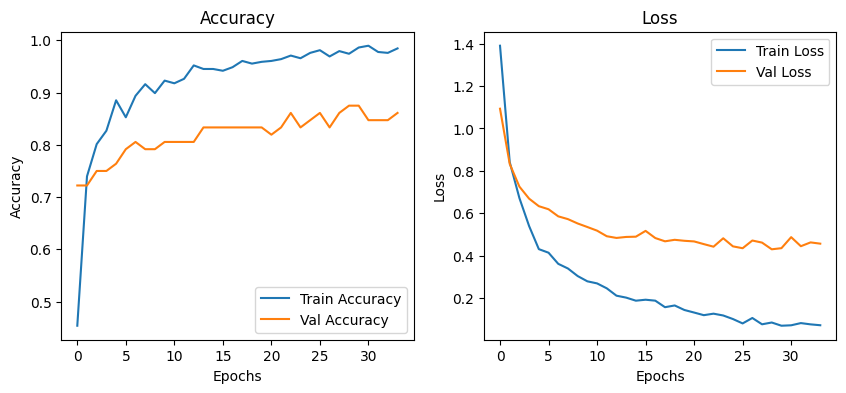

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss')

plt.show()


# EVALUATE MODEL

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
test_loss, test_acc = model.evaluate(test_data)

print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9141 - loss: 0.3345
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.9155 - loss: 0.3650

Validation Accuracy: 0.8750
Test Accuracy: 0.9014



# CONFUSION MATRIX & CLASSIFICATION REPORT

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step


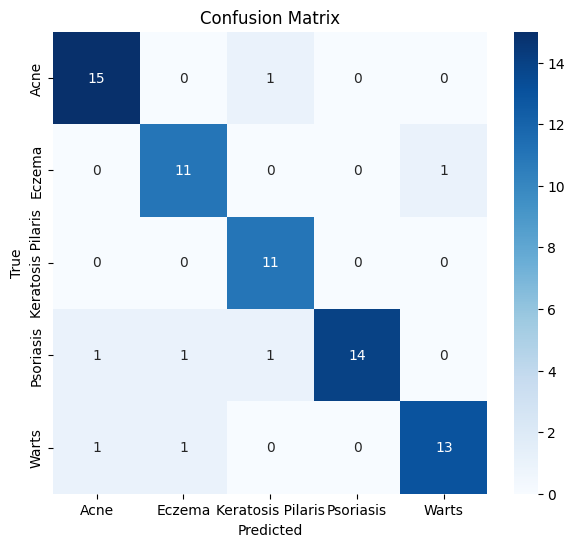


Classification Report:
                   precision    recall  f1-score   support

             Acne       0.88      0.94      0.91        16
           Eczema       0.85      0.92      0.88        12
Keratosis Pilaris       0.85      1.00      0.92        11
        Psoriasis       1.00      0.82      0.90        17
            Warts       0.93      0.87      0.90        15

         accuracy                           0.90        71
        macro avg       0.90      0.91      0.90        71
     weighted avg       0.91      0.90      0.90        71



In [ ]:
# Predict
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


# SAVE MODEL

In [ ]:
model.save("skin_disease_finetuned.h5")
print("Model saved as skin_disease_finetuned.h5")

Model saved as skin_disease_finetuned.h5


# LOAD MODEL

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the model
model = load_model("skin_disease_finetuned.h5")

# Load class names (same order as before)
class_labels = list(train_data.class_indices.keys())
print("Class labels:", class_labels)


Class labels: ['Acne', 'Eczema', 'Keratosis Pilaris', 'Psoriasis', 'Warts']


# PREDICT

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


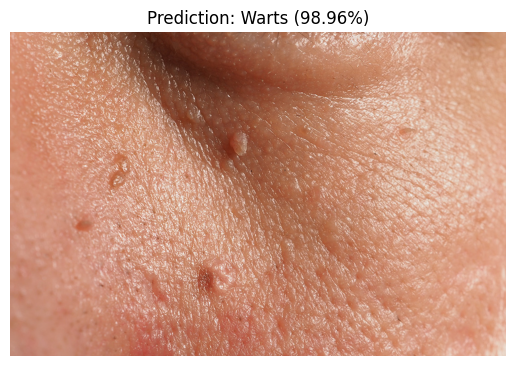

Predicted Class: Warts
Confidence: 98.96%


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Path to a test image
img_path = "/content/Warts.jpg"  #Change this path

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred)
pred_label = class_labels[pred_class]
confidence = np.max(pred) * 100

# Display result
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {pred_label} ({confidence:.2f}%)")
plt.axis('off')
plt.show()

print(f"Predicted Class: {pred_label}")
print(f"Confidence: {confidence:.2f}%")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')